# Описание задачи

В этом задании необходимо достичь максимального качества предсказания, используя навыки полученные за 4 недели обучения

Кто достигнет максимального значения на тестовой выборке, получит *15 баллов*

Пожалуйста, оформляйте ноутбук аккуратно. Все выводы подписывайте, оформляйте заголовки.

Для справедливой оценки все должны использовать одну и ту же часть исходного датасета в качестве тестового набора данных. Используйте разбиение приведенное ниже


```
train_test_split(X, y, test_size = 0.3, random_state = 69)
```
И модель, с которой вы работаете - это линейная регрессия. Другие алгоритмы не используйте.

Метрика, которую вы должны максимизировать

```
r2_score(y_test, y_pred) и root_mean_squared_error(y_test, y_pred)
```

Целевая переменная - *count*

Обратите внимание на столбцы - 'casual', 'registered'. Эти столбцы в сумме дают целевую переменную, по этой причине их надо удалить. Они линейно зависимы.




Используйте средства библиотеки sklearn, внимательно изучите ее. Существует огромное количество методов для выполнения каждого из этапов, не бойтесь использовать методы неприведенные в лекции


Этапы, которые необходимо проделать в работе для успешного достижения результата:
* EDA (Исследовать данные, понять с чем имеете дело, наработать идеи для генерации фичей и их обработки, обязательно корреляционные матрицы и графики с hue=классы объектов)
* Анализ выбросов и их обработка (в задачах классификации выброс - это объект с таким признаковым описанием, которое отличается очень сильно от типичного и больше соответствует другому классу)
* Генерация новых фичей
* Обработка пропусков (вы можете сгенерировать новые фичи с пропусками, тогда надо подумать об их обработке)
* Обработка категориальных признаков
* Масштабирование вещественных признаков
* Трансформирование таргета
* Нелинейные автоматические трансформации признаков (Kernel Trick, Transfomers)
* Подбор параметров модели (можете менять не только константы, но и оптимизационные алгоритмы и методы регуляризации)
* Отбор признаков
* Обязательно: Составление пайплайна обучения
* Обязательно: Постройте график зависимости y_pred от y_true в разбиении на test и train. Предсказание идеального алгоритма даст прямую y=x, посмотрите какой график получается у вас.

# Bike Sharing Demand
По историческим данным о прокате велосипедов и погодным условиям необходимо оценить спрос на прокат велосипедов.

В наборе признаков присутствуют вещественные, категориальные, и бинарные данные.

***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

### Библиотеки

In [2]:
%pylab inline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [3]:
df = pd.read_csv('bike_sharing_demand.csv')

#### Сразу разделим данные на обучение и на тестирование, а также удалим registered и casual

In [4]:
df = df.drop(['casual', 'registered'], axis=1)

X = df.drop('count', axis=1)
y = df['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

X_train['datetime'] = pd.to_datetime(X_train['datetime'], format='%Y-%m-%d %H:%M:%S')
X_test['datetime'] = pd.to_datetime(X_test['datetime'], format='%Y-%m-%d %H:%M:%S')

## Проведем EDA, для этого объединим обучаемые X и y.

In [5]:
data = pd.concat([X_train, y_train], axis=1)

data['year'] = pd.to_datetime(data['datetime']).dt.year
data['month'] = pd.to_datetime(data['datetime']).dt.month
data['day'] = pd.to_datetime(data['datetime']).dt.day
data['hour'] = pd.to_datetime(data['datetime']).dt.hour
data.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
6867,2012-04-04 11:00:00,2,0,1,2,24.60,31.060,43,23.9994,213,2012,4,4,11
5296,2011-12-14 18:00:00,4,0,1,2,14.76,17.425,62,11.0014,390,2011,12,14,18
8897,2012-08-13 02:00:00,3,0,1,1,26.24,30.305,69,7.0015,9,2012,8,13,2
7773,2012-06-04 06:00:00,2,0,1,1,21.32,25.000,68,0.0000,139,2012,6,4,6
355,2011-01-16 07:00:00,1,0,0,2,9.84,10.605,56,19.9995,3,2011,1,16,7
5192,2011-12-10 10:00:00,4,0,0,1,13.12,15.150,57,16.9979,192,2011,12,10,10
5367,2011-12-17 17:00:00,4,0,0,1,10.66,12.880,48,15.0013,165,2011,12,17,17
2419,2011-06-08 17:00:00,2,0,1,1,37.72,42.425,35,15.0013,506,2011,6,8,17
4868,2011-11-15 22:00:00,4,0,1,2,18.86,22.725,88,7.0015,128,2011,11,15,22
5772,2012-01-15 16:00:00,1,0,0,1,9.02,10.605,29,19.9995,205,2012,1,15,16


In [6]:
data.tail(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
2136,2011-05-15 22:00:00,2,0,0,1,22.96,26.515,83,0.0000,117,2011,5,15,22
5472,2012-01-03 03:00:00,1,0,1,1,6.56,6.820,55,19.0012,2,2012,1,3,3
1830,2011-05-03 04:00:00,2,0,1,1,21.32,25.000,88,15.0013,4,2011,5,3,4
9225,2012-09-07 18:00:00,3,0,1,1,31.16,35.605,62,19.9995,792,2012,9,7,18
4374,2011-10-14 07:00:00,4,0,1,3,22.96,26.515,88,12.9980,147,2011,10,14,7
8631,2012-08-02 00:00:00,3,0,1,1,28.70,33.335,74,0.0000,63,2012,8,2,0
9818,2012-10-13 11:00:00,4,0,0,1,17.22,21.210,35,8.9981,527,2012,10,13,11
10859,2012-12-18 21:00:00,4,0,1,1,14.76,17.425,50,15.0013,168,2012,12,18,21
4041,2011-09-19 10:00:00,3,0,1,2,22.96,26.515,64,8.9981,105,2011,9,19,10
7371,2012-05-06 12:00:00,2,0,0,2,24.60,30.305,64,6.0032,558,2012,5,6,12


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7620 entries, 6867 to 7371
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    7620 non-null   datetime64[ns]
 1   season      7620 non-null   int64         
 2   holiday     7620 non-null   int64         
 3   workingday  7620 non-null   int64         
 4   weather     7620 non-null   int64         
 5   temp        7620 non-null   float64       
 6   atemp       7620 non-null   float64       
 7   humidity    7620 non-null   int64         
 8   windspeed   7620 non-null   float64       
 9   count       7620 non-null   int64         
 10  year        7620 non-null   int32         
 11  month       7620 non-null   int32         
 12  day         7620 non-null   int32         
 13  hour        7620 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(4), int64(6)
memory usage: 773.9 KB


In [8]:
data.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
count,7620,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000
mean,2011-12-25 21:11:08.031496192,2.501837,0.028346,0.682021,1.416273,20.207619,23.615991,61.906562,12.855019,191.631890,2011.499475,6.508005,9.936745,11.503675
min,2011-01-01 02:00:00,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,2011-07-02 17:45:00,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,42.000000,2011.000000,4.000000,5.000000,6.000000
50%,2011-12-19 18:30:00,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,145.000000,2011.000000,7.000000,10.000000,11.000000
75%,2012-06-18 01:15:00,3.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,284.000000,2012.000000,9.000000,15.000000,18.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,970.000000,2012.000000,12.000000,19.000000,23.000000
std,NaN,1.113990,0.165972,0.465722,0.633698,7.809176,8.495028,19.251588,8.185204,180.993285,0.500033,3.444734,5.459146,6.923247


<Axes: xlabel='datetime', ylabel='count'>

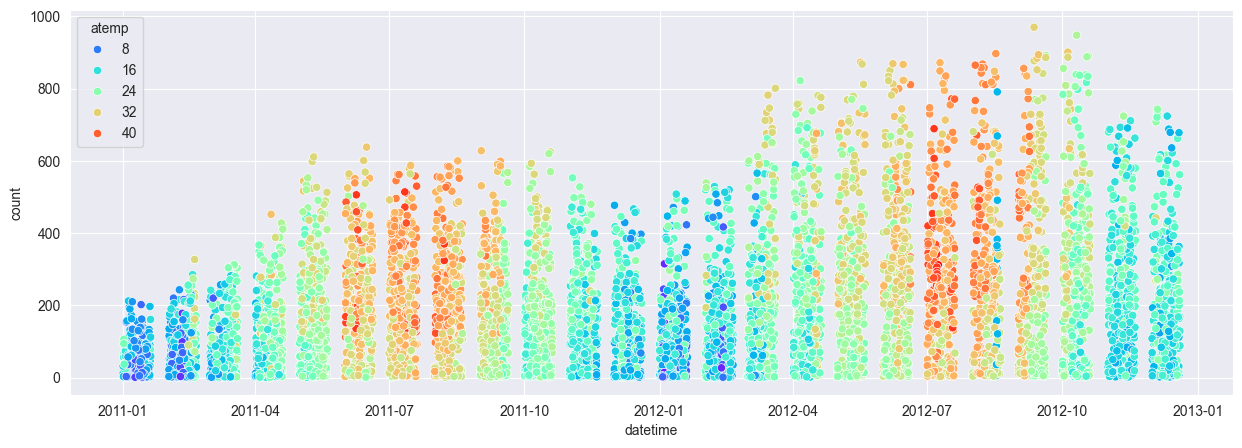

In [9]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=data, x='datetime', y='count', hue='atemp', palette='rainbow')

#### На этом графике можно увидеть, что спрос в более теплую погоду выше. Также можно увидеть, что прокат велосипедов стал популярнее в 2012 году. Видно, что есть некоторые значения ощущаемой температуры, которые сильно отличаются от соседних в августе 2012.

(array([14975., 15065., 15156., 15248., 15340., 15431., 15522., 15614.,
        15706.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15065.0, 0, '2011-04'),
  Text(15156.0, 0, '2011-07'),
  Text(15248.0, 0, '2011-10'),
  Text(15340.0, 0, '2012-01'),
  Text(15431.0, 0, '2012-04'),
  Text(15522.0, 0, '2012-07'),
  Text(15614.0, 0, '2012-10'),
  Text(15706.0, 0, '2013-01')])

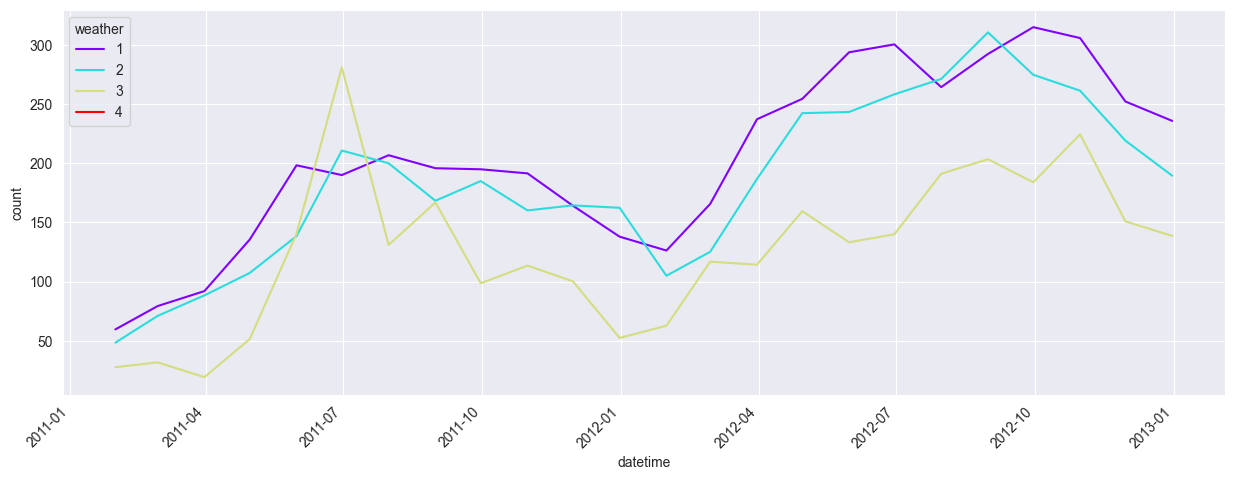

In [10]:
weather_count = data.groupby([pd.Grouper(key='datetime', freq='ME'), 'weather'])['count'].mean().reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(hue='weather', x='datetime', y='count', data=weather_count, palette='rainbow')
plt.xticks(rotation=45, ha='right')

#### Чем хуже погода, тем меньше спроса

<Axes: xlabel='weather', ylabel='count'>

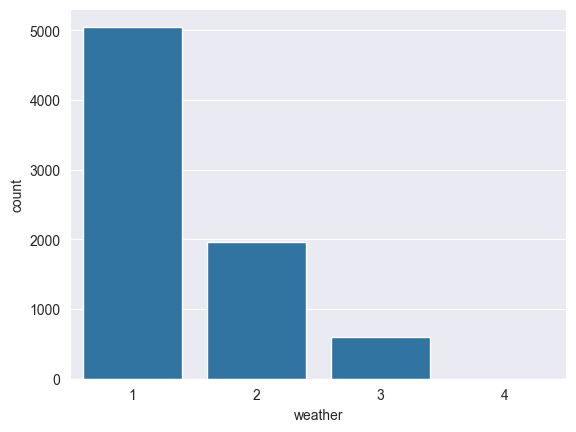

In [11]:
sns.countplot(x='weather', data=data, stat='count')

#### Погода типа 3 встречается 10 раз реже, чем 1 и 2 типа. Погода типа 4 практически не бывает.

<Axes: xlabel='datetime', ylabel='None'>

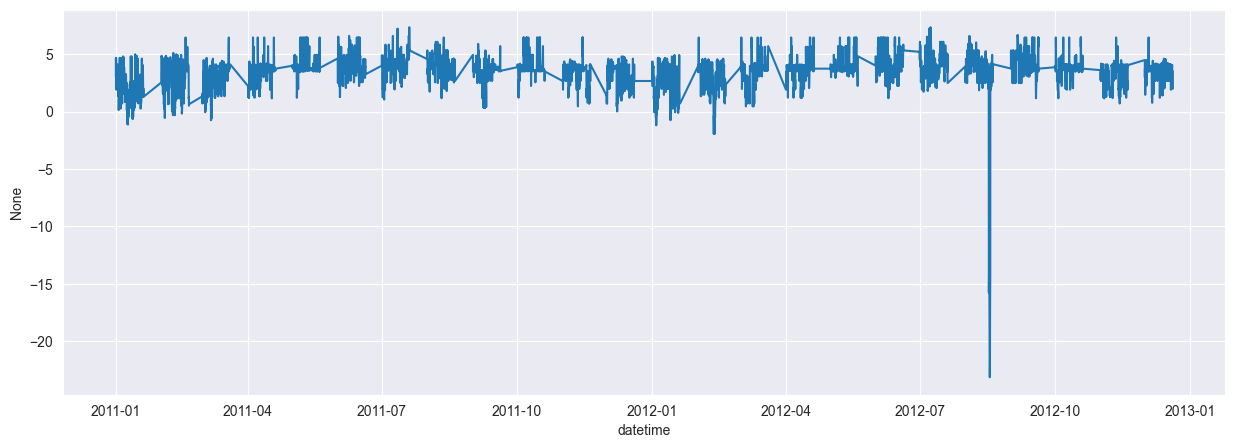

In [12]:
plt.figure(figsize=(15,5))
sns.lineplot(x=data['datetime'], y=(data['atemp'] - data['temp']))

#### Разница между ощущаемой температуры и реальной температуры в основном выше 0 и держится в диапазоне примерно 5 градусов, в январе и феврале эта разница иногда ниже нуля. Видно сильный выброс в графике. В целом эти два параметра линейно зависимые.

<Axes: xlabel='humidity', ylabel='count'>

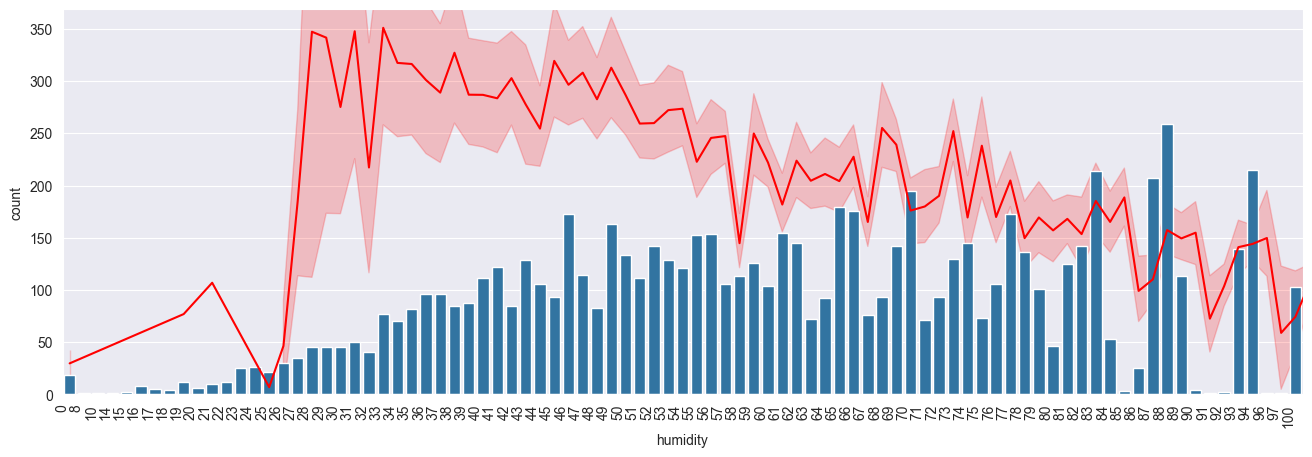

In [13]:
plt.figure(figsize=(16,5))
plt.xticks(rotation=90, ha='right')
sns.lineplot(x=data['humidity'], y=data['count'], color='r')
sns.countplot(x=data['humidity'])

#### Чем больше влажность, тем меньше спрос, также при засушливой погоде.

<Axes: xlabel='windspeed', ylabel='count'>

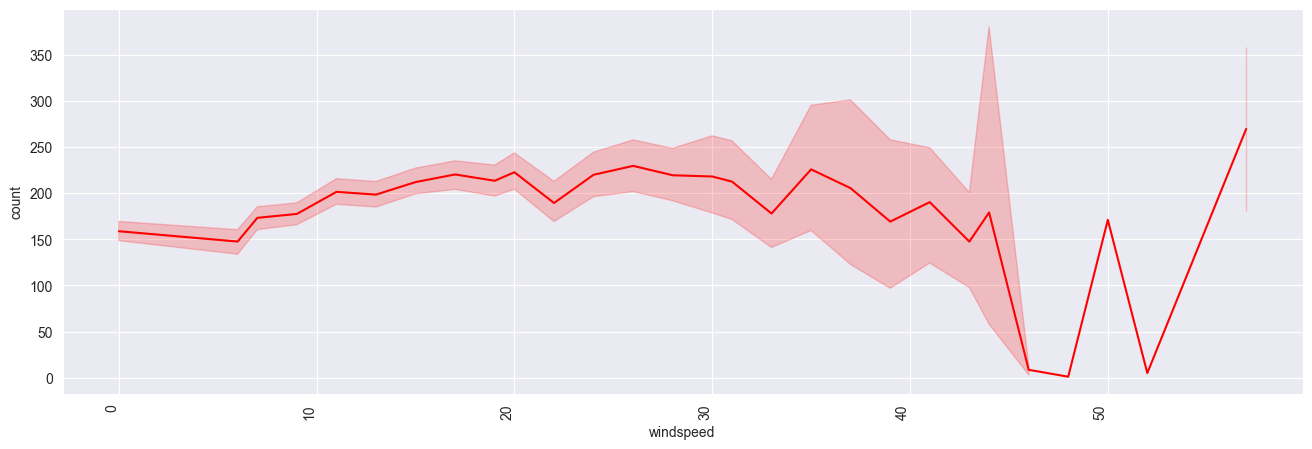

In [14]:
plt.figure(figsize=(16,5))
plt.xticks(rotation=90, ha='right')
sns.lineplot(x=data['windspeed'], y=data['count'], color='r')

#### При скорости ветра 40 и выше спрос падает

<Axes: xlabel='datetime', ylabel='count'>

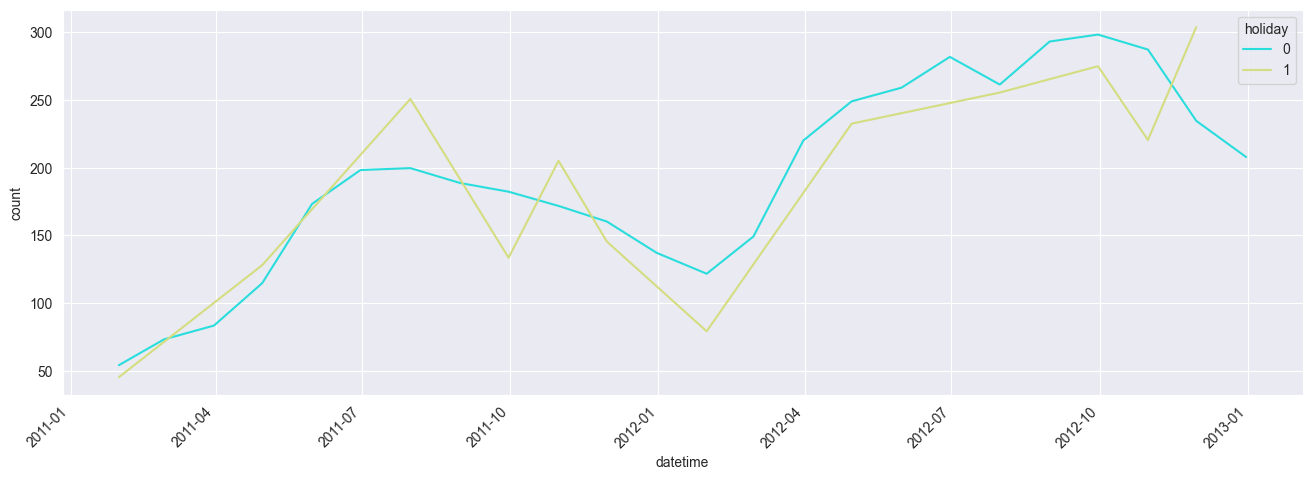

In [15]:
holiday_count = data.groupby([pd.Grouper(key='datetime', freq='ME'), 'holiday'])['count'].mean().reset_index()
plt.figure(figsize=(16,5))
plt.xticks(rotation=45, ha='right')
sns.lineplot(hue='holiday', x='datetime', y='count', data=holiday_count, palette='rainbow')

<Axes: xlabel='datetime', ylabel='count'>

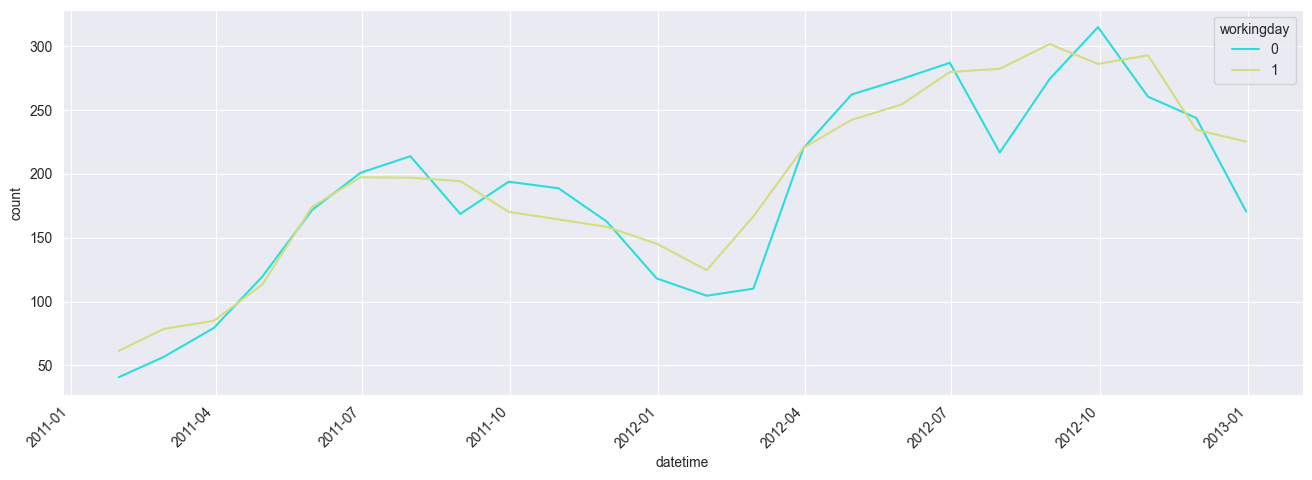

In [16]:
workingday_count = data.groupby([pd.Grouper(key='datetime', freq='ME'), 'workingday'])['count'].mean().reset_index()
plt.figure(figsize=(16,5))
plt.xticks(rotation=45, ha='right')
sns.lineplot(hue='workingday', x='datetime', y='count', data=workingday_count, palette='rainbow')

#### В рабочие и нерабочие дни спрос особо не отличается, также с праздничными и непраздничными днями.
#### Построим матрицу корреляции

<Axes: >

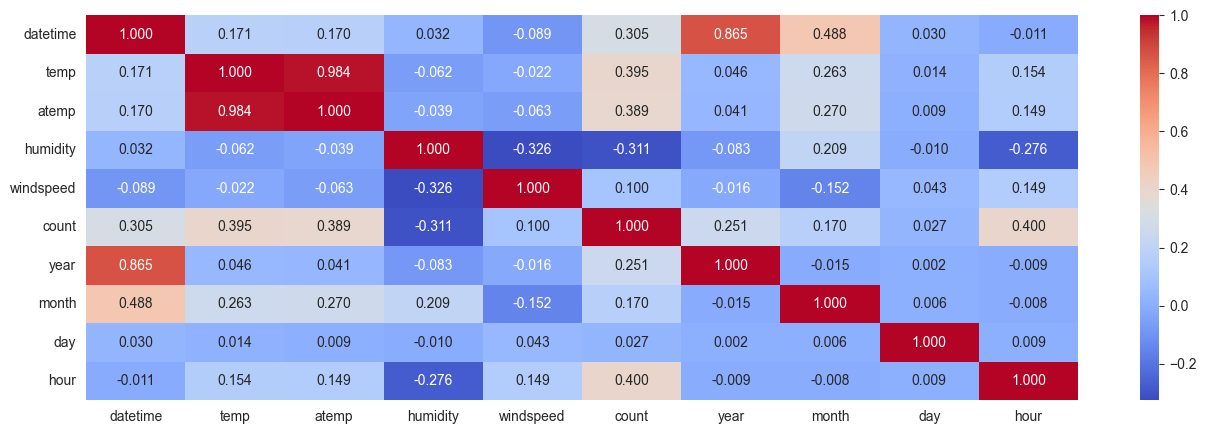

In [17]:
corr_matrix = data.drop(['season', 'holiday', 'workingday', 'weather'], axis=1).corr()
plt.figure(figsize=(16,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f')

## Нужно проанализировать выбросы и обработать их.
#### В некоторых графиках мы можем видеть такие значения, которые сильно отличаются от других. Посмотрим на параметры, в которых такое возможно, а именно на показатели погодных условий. Изобразим их с помощью японских свеч.

<Axes: >

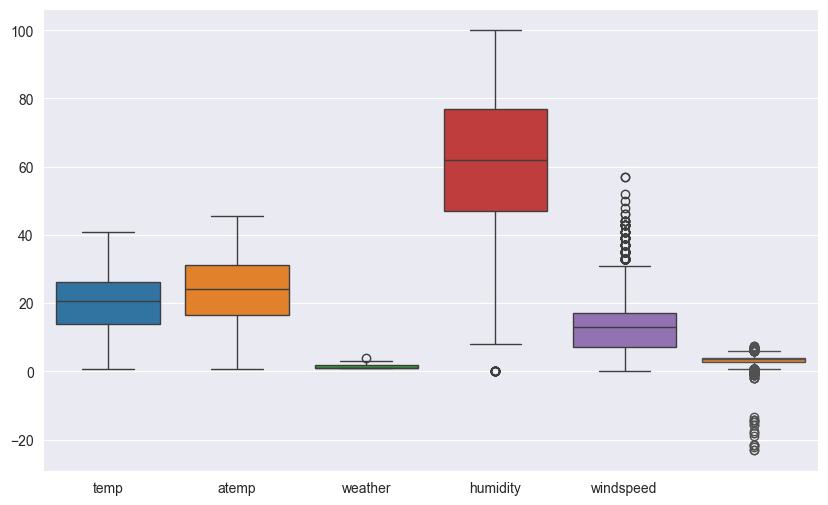

In [18]:
selected_columns = ['temp', 'atemp', 'weather', 'humidity', 'windspeed']

plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train[selected_columns])

# На графике разницы atemp и temp видно сильный выброс в августе 2012, 
# хотя эти графики линейно зависимы. Посмотрим также и на это.
sns.boxplot(data=(X_train['atemp'] - X_train['temp']))

#### На графике наглядно видно выбросы, обозначенные за точки. Также давайте найдем и обработаем выбросы с помощью статистического метода IQR. Для этого просто найдем эти выбросы и заменим на граничные значения.

<Axes: >

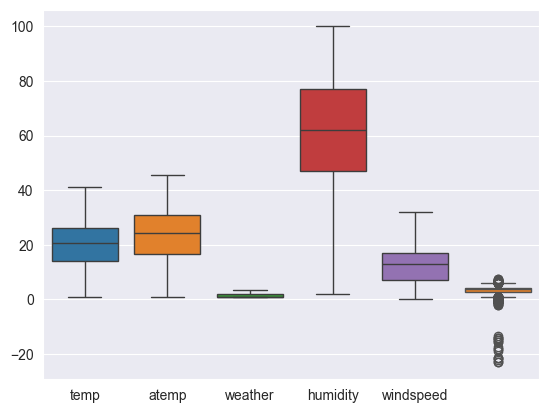

In [19]:
for column in selected_columns:
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Граничные значения
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    X_train[column] = X_train[column].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    
sns.boxplot(data=X_train[selected_columns])
sns.boxplot(data=(X_train['atemp'] - X_train['temp']))

#### Избавились от выбросов во всех переменных, однако есть значения atemp которые сильно отличаются от temp (особенно холодные температуры в августе 2012). Просто заменим эти значения на значения из столбца temp и прибавим граничные значения.

<Axes: >

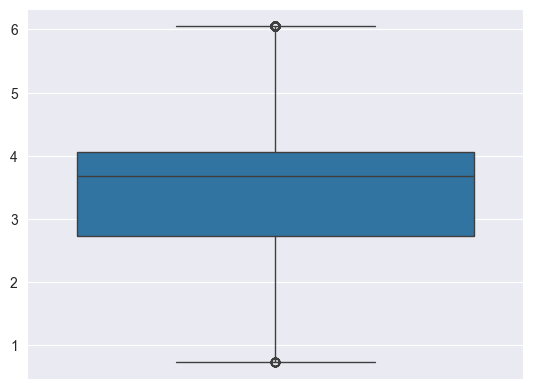

In [20]:
Q1 = (X_train['atemp'] - X_train['temp']).quantile(0.25)
Q3 = (X_train['atemp'] - X_train['temp']).quantile(0.75)
IQR = Q3 - Q1

# Граничные значения
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Рассчитываем разницу между 'atemp' и 'temp'
diff = X_train['atemp'] - X_train['temp']

X_train['atemp'] = np.where(diff < lower_bound, X_train['temp'] + lower_bound,
                   np.where(diff > upper_bound, X_train['temp'] + upper_bound, X_train['atemp']))

sns.boxplot(data=(X_train['atemp'] - X_train['temp']))

## Пропуски в выборке отсутствуют

## Построим pipeline

In [21]:
# Генератор фич

class FeatureGenerator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        X['year'] = pd.to_datetime(X['datetime']).dt.year
        X['month'] = pd.to_datetime(X['datetime']).dt.month
        X['day'] = pd.to_datetime(X['datetime']).dt.day
        X['hour'] = pd.to_datetime(X['datetime']).dt.hour
        
        X['hour_sin'] = np.sin(2 * np.pi * X['hour']/24)
        X['hour_cos'] = np.cos(2 * np.pi * X['hour']/24)
        X['month_sin'] = np.sin(2 * np.pi * X['month']/12)
        X['month_cos'] = np.cos(2 * np.pi * X['month']/12)
        X['day_sin'] = np.sin(2 * np.pi * X['day']/31)
        X['day_cos'] = np.cos(2 * np.pi * X['day']/31)
        X['weekday_sin'] = np.sin(2 * np.pi * X['weekday']/7)
        X['weekday_cos'] = np.cos(2 * np.pi * X['weekday']/7)
        
        X['weekday'] = pd.to_datetime(X['datetime']).dt.weekday
        X['is_weekend'] = (X['weekday'] >= 5).astype(int)
        X['season_weather'] = X['season'].astype(str) + X['weather'].astype(str)
        X['workingday_hour'] = X['workingday'].astype(str) + X['hour'].astype(str)
        
        X['temp_humidity'] = X['temp'] * X['humidity']
        X['temp_windspeed'] = X['temp'] * X['windspeed']
        X['humidity_windspeed'] = X['windspeed'] * X['humidity']
    
        X = X.drop(['datetime', 'atemp'], axis=1)
        return X

# Обработка вещественных признаков

numeric_cols = ['temp', 'humidity', 'windspeed', 'temp_humidity', 'temp_windspeed', 'humidity_windspeed',
                'hour', 'day', 'month', 'year', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_cos',
                'day_sin', 'weekday_cos', 'weekday_sin']
categorical_cols = ['season', 'holiday', 'workingday', 'weather',
                'weekday', 'is_weekend', 'season_weather', 'workingday_hour']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ])

# Модель

model = TransformedTargetRegressor(
    regressor=Pipeline(steps=[
    ('feature_generator', FeatureGenerator()),
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', Ridge()),
]),
    transformer=PowerTransformer()
)

model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_generator',
                                                      FeatureGenerator()),
                                                     ('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       StandardScaler(),
                                                                                       ['temp',
                                                                                        'humidity',
                                                                                        'windspeed',
                                                                                        'temp_humidity',
                                                                                        'temp_windspeed',
                                                                                        'humidity_windspeed',
                                                                                        'hour',
                                                                                        'day',
                                                                                        'month',
                                                                                        'year',
                                                                                        'hour_sin',
                                                                                        'hour_cos',
                                                                                        'month_sin',
                                                                                        'month_cos',
                                                                                        'day_cos',
                                                                                        'day_sin',
                                                                                        'weekday_cos',
                                                                                        'weekday_sin']),
                                                                                      ('cat',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['season',
                                                                                        'holiday',
                                                                                        'workingday',
                                                                                        'weather',
                                                                                        'weekday',
                                                                                        'is_weekend',
                                                                                        'season_weather',
                                                                                        'workingday_hour'])])),
                                                     ('poly',
                                                      PolynomialFeatures(include_bias=False)),
                                                     ('regressor', Ridge())]),
                           transformer=PowerTransformer())

# Посчитаем RMSE и R2 score

In [22]:
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse_t = root_mean_squared_error(y_train, y_pred_train)
r2_t = r2_score(y_train, y_pred_train)

print("TEST:")
print(f"MSE: {rmse}")
print(f"R2: {r2}")

print("\nTRAIN:")
print(f"MSE: {rmse_t}")
print(f"R2: {r2_t}")

TEST:
MSE: 48.64946170379402
R2: 0.9281512259757008

TRAIN:
MSE: 31.835222339938763
R2: 0.9690580380156089


# Графики

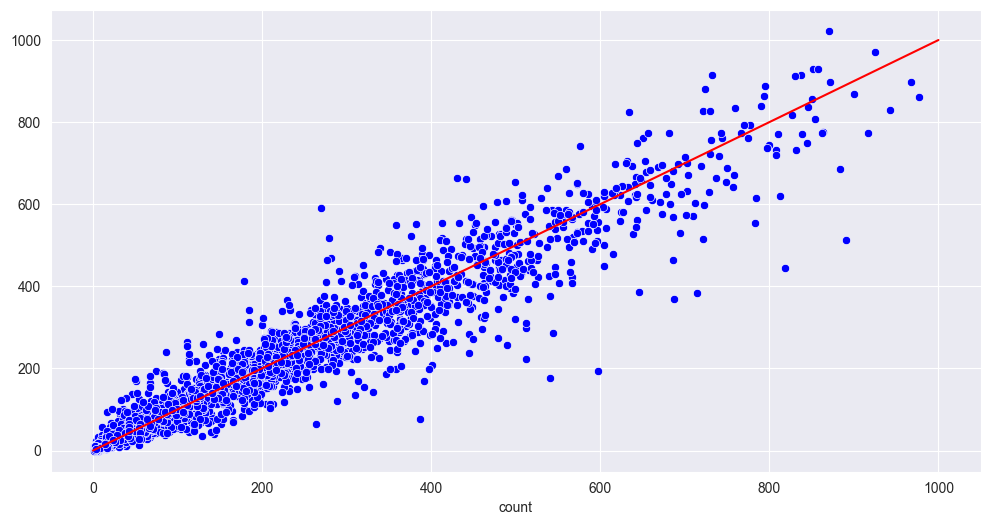

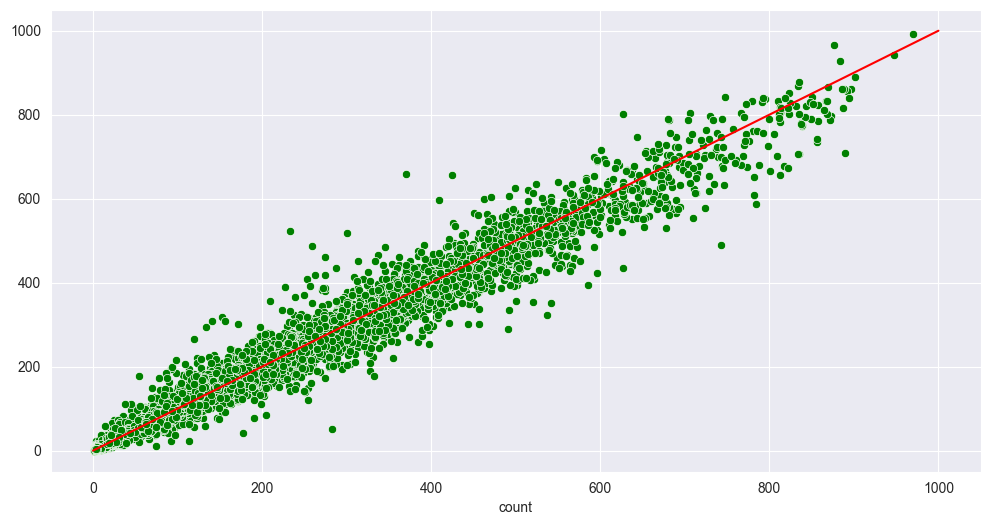

In [23]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=y_test, y=y_pred, color='b')
plt.plot([0,1000], [0, 1000], color='r')

plt.figure(figsize=(12,6))
sns.scatterplot(x=y_train, y=y_pred_train, color='g')
plt.plot([0,1000], [0, 1000], color='r')